In [1]:
% matplotlib inline

import numpy as np

from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import h5py
import pywt

import readligo as rl

In [2]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs)/dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [3]:
fs = 4096 # sampling rate

# get segment list. note that for now, I'm only using a small amount of
# data (1 file), but that this should be expandable to many more (currently
# I have about 50GB worth of data cached on my home desktop, which should
# be more than enough for this)
start = 931049472
stop = 931053568
segList = rl.getsegs(start, stop, 'H1', flag='DATA')

Using data directory . ...


Using data directory . ...
Loading ./cache/H-H1_LOSC_4_V1-931049472-4096.hdf5
(2,)
----------
(2,)


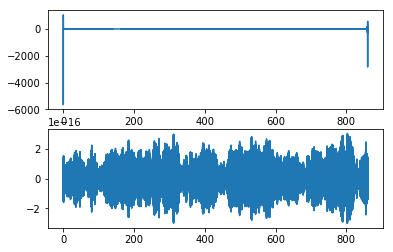

In [13]:
# loop over good segments
N = 10000
for (begin, end) in segList:
    strain, meta, dq = rl.getstrain(begin, end, 'H1')
    ts = meta['dt']
    
    # first whiten strain data
    NFFT = 1*fs    
    Pxx, freqs = mlab.psd(strain, Fs=fs, NFFT=NFFT)
    psd = interp1d(freqs, Pxx)
    
    strain_whiten = whiten(strain,psd,ts)
    
    bb, ab = butter(4, [20.*2./fs, 300.*2./fs],btype='band') #butterworth bandpass
    strain_whitenbp = filtfilt(bb, ab, strain_whiten)
    
    # then wavelet decomposition.
    # returns [cA_n, cD_n, cD_n-1, ..., cD2, cD1]
    # where n is the decomposition level, and cA are the approximation coefficient arry
    # while cD are details coefficient arrays
    coeffs = pywt.wavedec(strain_whitenbp, 'haar') # using haar for now, as thats what LIGO apparently uses for this. will do more research later to verify reasoning
    D_coeffs = np.flipud(coeffs[1:]) # switching the order so that D_coeffs[i] corresponds to j=i+1 decomp level
    
    # normalize the coefficients - WIP: currently need to figure out how to 
    # put these all back into a single array the same shape as D_coeffs
    # this is complicated by the fact that the arrays along axis 0 are all
    # different shapes, and numpy does not seem to like that
    sq_norm_coeffs = []
    for D_co in D_coeffs:
        normed = ((D_co**2) /  (np.std(D_co)**2))
        sq_norm_coeffs.append(normed)
    
    # plot of the whitened data and unwhitened data
    # not really relevant to final goals, but it shows the whitening is working!
    plt.subplot(2,1,1)
    rel_time = np.arange(0, end-begin, ts)
    
    plt.plot(rel_time, strain_whitenbp)
    plt.xlabel('Seconds since GPS ' + str(begin))
    
    plt.subplot(2,1,2)
    plt.plot(rel_time, strain)
    
plt.show()